<a href="https://colab.research.google.com/github/acoj1993/fake-news-deeplearning/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Network for detecting fake news**
## **The neural network constructed and trained in this notebook is based on the work done in [1]. The network proposed in this paper is completely redisgned, however the core idea behind is preserved. For more details please refer to README.md of this repository.**

## The training and testing dataset used in this notebook is the TI-CNN dataset.




---



*   The variable **MAX_NO_OF_WORDS** is used (as instructed in [1]) to define 
the input size of the neural network. The value 1606 is calculated in [1] as an optimal value for the text (also called body) feature of the dataset.
*   **EMBEDDING_DIMENSION** obviously defines the embedding dimnesion and is set to 100. The words are embedded using word2vec Glove model.

In [1]:
import keras
import numpy as np

MAX_NO_OF_WORDS = 1606
EMBEDDING_DIMENSION = 100

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/all_data.csv')
data.title[1]

'Trump Foundation Tells New York It Has Stopped Soliciting After State Order'

In [4]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/all_data.csv')
print(data.columns)
print(data[0:10])

data['type'] = data['type'].replace('fake', 0)
data['type'] = data['type'].replace('real', 1)

texts = []
labels = []

for i in range(data.text.shape[0]):
    text = data.text[i]
    texts.append(text)
    label = data.type[i]
    labels.append(label)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'text', 'thread_title', 'title',
       'type', 'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'],
      dtype='object')
   Unnamed: 0  Unnamed: 0.1  ... second_all  third_all
0           1           NaN  ...        150         45
1           2           NaN  ...         38         28
2           3           NaN  ...        1

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique tokens for the feature text is %s' % len(word_index))

Number of Unique tokens for the feature text is 140674


In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen=MAX_NO_OF_WORDS)
print('Shape of text data:', data.shape)

labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of label data:', labels.shape)

Shape of text data: (20015, 1606)
Shape of label data: (20015, 2)


In [7]:
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

test_size = 0.3
validaiton_size = 0.3

X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=validaiton_size, random_state=42)

print('Size of train, test for the text:', len(y_train), len(y_test))

Size of train, test for the text: 9807 6005


In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-01-13 18:32:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-13 18:32:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-13 18:32:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [9]:
!unzip /content/drive/My\ Drive/glove.6B.zip

Archive:  /content/drive/My Drive/glove.6B.zip
  inflating: glove.6B.50d.txt        

In [10]:
import os
from keras.layers import Embedding

embeddings_index = {}
f = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIMENSION))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_NO_OF_WORDS)

# **CNN Architecture**
## For better understanding of the model used, please refer to the following image of the architecture.

![](https://drive.google.com/uc?id=13RdD9MEzDLgRr0DwpHuU8bNYsfAaMG1N)


In [11]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model

sequence_input = Input(shape=(MAX_NO_OF_WORDS,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

branches = []
filter_sizes = [3,4,5]

for filter_size in filter_sizes:
    text_conv = Conv1D(nb_filter=42,filter_length=filter_size, activation='relu')(embedded_sequences)
    text_maxpool = MaxPooling1D(5)(text_conv)
    branches.append(text_maxpool)
    
merge = Concatenate(axis=1)(branches)
conv_1= Conv1D(filters=128, kernel_size=5, activation='relu')(merge)
max_pool_1 = MaxPooling1D(5)(conv_1)
conv_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(max_pool_1)
max_pool_2 = MaxPooling1D(30)(conv_2)
flat = Flatten()(max_pool_2)
dense_1 = Dense(128, activation='relu')(flat)
dropout_1 = Dropout(0.110)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(0.159)(dense_2)
dense_3 = Dense(128, activation='relu')(dropout_2)
dropout_3 = Dropout(0.159)(dense_3)
dense_out = Dense(2, activation='softmax')(dropout_3)

model = Model(sequence_input, dense_out)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'])

model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=50)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=42, kernel_size=3)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=42, kernel_size=4)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=42, kernel_size=5)`
  if sys.path[0] == '':


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1606)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1606, 100)    14067500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1604, 42)     12642       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1603, 42)     16842       embedding_1[0][0]                
____________________________________________________________________________________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


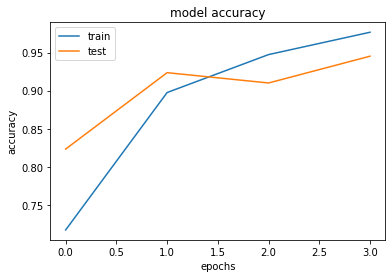

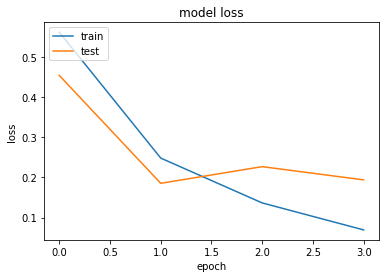

In [12]:
print(history.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Loss on test:', score[0])
print('Accuracy on test:', score[1])

Loss on test: 0.1717653066838016
Accuracy on test: 0.951873438810925


In [0]:
model.save('drive/My Drive/model.h5')

In [0]:
from google.colab import files
files.download("drive/My Drive/model.h5")